# 深度学习初始化trick

n_in为网络的输入大小，n_out为网络的输出大小，n为n_in或(n_in+n_out) * 0.5   。
* uniform均匀分布初始化：w = np.random.uniform(low=-scale, high=scale, size=[n_in,n_out])
    * Xavier初始法，适用于普通激活函数(tanh,sigmoid)：scale = np.sqrt(3/n)
    * He初始化，适用于ReLU：scale = np.sqrt(6/n) 

* normal高斯分布初始化：w = np.random.randn(n_in,n_out) * stdev # stdev为高斯分布的标准差，均值设为0
    * Xavier初始法，适用于普通激活函数 (tanh,sigmoid)：stdev = np.sqrt(1/n)
    * He初始化，适用于ReLU：stdev = np.sqrt(2/n)


## 1. 背景
近几年，Xavier初始化方法被广泛使用，why？    
**机器学习**中，损失函数是convex函数，初始化参数全部为0或随机数是可行的，不论权重初始值如何，模型终究会收敛。   
**深度学习**中，由于非线性函数的叠加，损失函数是non-convex函数，初始化参数全部为0或随机数会产生梯度消失或网络饱和问题，而Xavier初始化方法正好解决了这些问题。

## 2. 为什么不全部初始化为0？

如果将参数全部初始化为0，则同一层的每个神经元的输入是一样的，经激活函数也是输出一样，反向传播时同一层的每个神经元的梯度也会一样，因此权重更新也一样，那就相当于一层一个神经元啦！nonsense！

## 3. 高斯初始化
### 3.1 初始化w的均值为0，方差为1

使用tanh激活函数，当初始化w为均值为0，方差为1的标准正态分布时，绝大多数神经元的输出
都在-1或1附近，而tanh在-1和1附近的gradient小，神经元饱和，相应的权重更新慢或不更新了。

layer_sizes: [100, 95, 90, 85, 80, 75, 70, 65, 60, 55]
input mean -0.00575 and std 0.99857
layer 1 mean 0.00301 and std 0.96024
layer 2 mean -0.01142 and std 0.95658
layer 3 mean -0.00161 and std 0.95590
layer 4 mean 0.01158 and std 0.95456
layer 5 mean -0.01847 and std 0.95314
layer 6 mean 0.00228 and std 0.94857
layer 7 mean -0.01675 and std 0.94728
layer 8 mean 0.00305 and std 0.94970
layer 9 mean 0.01837 and std 0.94448


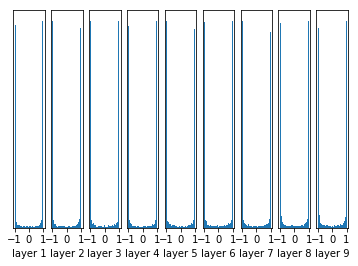

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

graph = tf.Graph()
with graph.as_default():
    data = tf.constant(np.random.randn(50, 100).astype('float32'))
    layer_sizes = [100 - 5 * i for i in range(0, 10)]
    print('layer_sizes:',layer_sizes)
    num_layers = len(layer_sizes)

    fcs = []
    for i in range(0, num_layers - 1):
        X = data if i == 0 else fcs[i - 1]
        node_in = layer_sizes[i]
        node_out = layer_sizes[i + 1]
        W = tf.Variable(np.random.randn(node_in, node_out).astype('float32'))
        fc = tf.matmul(X, W)
        fc = tf.nn.tanh(fc)

        fcs.append(fc)

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())

    print('input mean {0:.5f} and std {1:.5f}'.format(np.mean(data.eval()),
                                                      np.std(data.eval())))
    for idx, fc in enumerate(fcs):
        print('layer {0} mean {1:.5f} and std {2:.5f}'.format(idx + 1, np.mean(fc.eval()),
                                                              np.std(fc.eval())))

    plt.figure()
    for idx, fc in enumerate(fcs):
        plt.subplot(1, len(fcs), idx + 1)
        plt.hist(fc.eval().flatten(), 30, range=[-1,1])
        plt.xlabel('layer ' + str(idx + 1))
        plt.yticks([])

    plt.show()
    sess.close()

### 3.1 初始化w的均值为0，方差为0.01
使用tanh激活函数，当初始化w为均值为0，方差为0.01的标准正态分布时，几乎所有的神经元的输出
都在0附近，反向传播时梯度的计算会乘以神经元输出值，因此会有梯度消失问题。

layer_sizes: [100, 95, 90, 85, 80, 75, 70, 65, 60, 55]
input mean 0.00807 and std 0.97964
layer 1 mean 0.00252 and std 0.09779
layer 2 mean -0.00007 and std 0.00957
layer 3 mean -0.00001 and std 0.00088
layer 4 mean 0.00000 and std 0.00008
layer 5 mean 0.00000 and std 0.00001
layer 6 mean -0.00000 and std 0.00000
layer 7 mean -0.00000 and std 0.00000
layer 8 mean 0.00000 and std 0.00000
layer 9 mean 0.00000 and std 0.00000


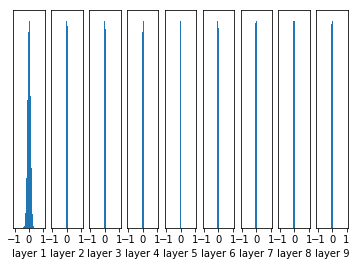

In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

graph = tf.Graph()
with graph.as_default():
    data = tf.constant(np.random.randn(50, 100).astype('float32'))
    layer_sizes = [100 - 5 * i for i in range(0, 10)]
    print('layer_sizes:',layer_sizes)
    num_layers = len(layer_sizes)

    fcs = []
    for i in range(0, num_layers - 1):
        X = data if i == 0 else fcs[i - 1]
        node_in = layer_sizes[i]
        node_out = layer_sizes[i + 1]
        W = tf.Variable(np.random.randn(node_in, node_out).astype('float32'))*0.01
        fc = tf.matmul(X, W)
        fc = tf.nn.tanh(fc)

        fcs.append(fc)

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())

    print('input mean {0:.5f} and std {1:.5f}'.format(np.mean(data.eval()),
                                                      np.std(data.eval())))
    for idx, fc in enumerate(fcs):
        print('layer {0} mean {1:.5f} and std {2:.5f}'.format(idx + 1, np.mean(fc.eval()),
                                                              np.std(fc.eval())))

    plt.figure()
    for idx, fc in enumerate(fcs):
        plt.subplot(1, len(fcs), idx + 1)
        plt.hist(fc.eval().flatten(), 30, range=[-1,1])
        plt.xlabel('layer ' + str(idx + 1))
        plt.yticks([])

    plt.show()
    sess.close()

## 4. Xavier初始化
### 4.1 基础知识
假设有随机变量x和w，它们都服从均值为0，方差为$\sigma$的分布，那么：
* w*x就会服从均值为0，方差为$\sigma^2$的分布  
* w*x+w*x就会服从均值为0，方差为$2*\sigma^2$的分布  

In [43]:
data0 = np.random.randn(500, 100)*5
data1 = np.random.randn(500, 100)*10
print(np.std(data0*data1),np.std(data0*data1+data0*data1))

49.27086124340513 98.54172248681026


### 4.2 Xavier基本原理
Xavier初始化的中心思想是**使每一层输入的方差和输出的方差保持一致**，从而使得样本空间和类别空间的差异变小，网络更容易学习到这个差异，更容易收敛。
假设输入数据x满足均值为0，方差为$\sigma_x$的分布，我们再将参数w以均值为0，方差为$\sigma_w$的方式进行初始化。
以一次卷积为例，卷积核有n个参数（n=channel * kernel_h * kernel_w）,且tanh激活函数在输入是0附近的图像可以看作是线性的，计算一个线性部分的结果为：$z_j=\sum^n_i{w_i*x_i}$         
$z_j$均值仍是0，方差则变成了$n*\sigma_x*\sigma_w$,加上层号标记，又可写成$\sigma^2_x=n^1*\sigma^1_x*\sigma^1_w$

为保证每一层输入和输出的方差相等，也就是$\sigma_x^2=\sigma_x^1$，于是要求：$\sigma^1_w=\frac{1}{n^1}$

-------------------------------
以上只是xavier提出的思路，事实上，xavier初始化方式为：在$[-\sqrt{\frac{6}{m+n}},\sqrt{\frac{6}{m+n}}]$的范围内均匀选取权重初始值，当前层的输入维度为n，输出维度为m。

### 4.3 tanh Xavier初始化 

layer_sizes: [100, 95, 90, 85, 80, 75, 70, 65, 60, 55, 50]
input mean 0.00841 and std 0.99356
layer 1 mean 0.00119 and layer_output var 0.38688 and layer_input var 0.99356 and  layer_weight var 0.01001
layer 2 mean 0.00262 and layer_output var 0.23029 and layer_input var 0.38688 and  layer_weight var 0.01051
layer 3 mean -0.00046 and layer_output var 0.16121 and layer_input var 0.23029 and  layer_weight var 0.01100
layer 4 mean 0.00660 and layer_output var 0.11960 and layer_input var 0.16121 and  layer_weight var 0.01133
layer 5 mean -0.00071 and layer_output var 0.09639 and layer_input var 0.11960 and  layer_weight var 0.01235
layer 6 mean -0.00104 and layer_output var 0.08508 and layer_input var 0.09639 and  layer_weight var 0.01353
layer 7 mean 0.00037 and layer_output var 0.07108 and layer_input var 0.08508 and  layer_weight var 0.01419
layer 8 mean 0.00155 and layer_output var 0.06218 and layer_input var 0.07108 and  layer_weight var 0.01523
layer 9 mean -0.00291 and layer_output 

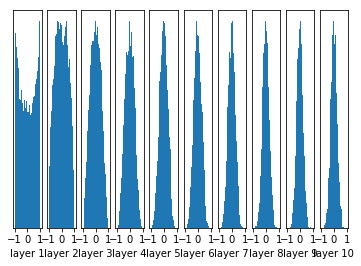

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

graph = tf.Graph()
with graph.as_default():
    data = tf.constant(np.random.randn(100, 100).astype('float32'))
    layer_sizes = [100 - 5 * i for i in range(0, 11)]
    print('layer_sizes:',layer_sizes)
    num_layers = len(layer_sizes)

    fcs = []
    layer_input = []
    Ws = []
    for i in range(0, num_layers-1):
        X = data if i == 0 else fcs[i - 1]
        node_in = layer_sizes[i]
        node_out = layer_sizes[i + 1]
        W = tf.Variable(np.random.randn(node_in, node_out).astype('float32'))/np.sqrt(node_in)
        fc = tf.matmul(X, W)
        fc = tf.nn.tanh(fc)

        fcs.append(fc)
        Ws.append(W)
        layer_input.append(X)

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())

    print('input mean {0:.5f} and std {1:.5f}'.format(np.mean(data.eval()),np.var(data.eval())))
    for idx, fc in enumerate(fcs):
        print('layer {0} mean {1:.5f} and layer_output var {2:.5f} and layer_input var {3:.5f} and  layer_weight var {4:.5f}'.format(idx + 1, np.mean(fc.eval()),
                                                              np.var(fc.eval()),np.var(layer_input[idx].eval()),np.var(Ws[idx].eval())))
    plt.figure()
    for idx, fc in enumerate(fcs):
        plt.subplot(1, len(fcs), idx + 1)
        plt.hist(fc.eval().flatten(), 30, range=[-1,1])
        plt.xlabel('layer ' + str(idx + 1))
        plt.yticks([])

    plt.show()
    sess.close()

以上各层的输入和输出的方差并不相等，原因是Xavier激活方法的假设是线性激活函数，此处我们用的tanh。但每层输出值在很多层之后依然保持着良好的分布，这很有利于我们优化神经网络。

### 4.4 relu Xavier初始化 
直接使用Xavier初始化随机，浅层的输出的分布ok，但深层的输出值也集中在0，会有梯度消失问题。

layer_sizes: [100, 95, 90, 85, 80, 75, 70, 65, 60, 55, 50]
input mean -0.01506 and std 0.99371
layer 1 mean 0.39848 and layer_output var 0.33576 and layer_input var 0.99371 and  layer_weight var 0.01009
layer 2 mean 0.26801 and layer_output var 0.16258 and layer_input var 0.33576 and  layer_weight var 0.01051
layer 3 mean 0.21504 and layer_output var 0.09175 and layer_input var 0.16258 and  layer_weight var 0.01091
layer 4 mean 0.16866 and layer_output var 0.05566 and layer_input var 0.09175 and  layer_weight var 0.01169
layer 5 mean 0.12373 and layer_output var 0.02690 and layer_input var 0.05566 and  layer_weight var 0.01247
layer 6 mean 0.08412 and layer_output var 0.01819 and layer_input var 0.02690 and  layer_weight var 0.01354
layer 7 mean 0.05438 and layer_output var 0.00662 and layer_input var 0.01819 and  layer_weight var 0.01389
layer 8 mean 0.03563 and layer_output var 0.00242 and layer_input var 0.00662 and  layer_weight var 0.01561
layer 9 mean 0.03135 and layer_output var

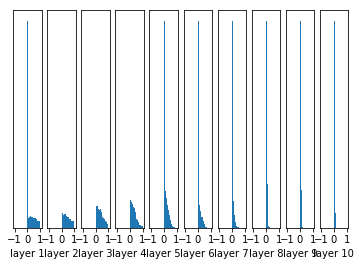

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

graph = tf.Graph()
with graph.as_default():
    data = tf.constant(np.random.randn(100, 100).astype('float32'))
    layer_sizes = [100 - 5 * i for i in range(0, 11)]
    print('layer_sizes:',layer_sizes)
    num_layers = len(layer_sizes)

    fcs = []
    layer_input = []
    Ws = []
    for i in range(0, num_layers-1):
        X = data if i == 0 else fcs[i - 1]
        node_in = layer_sizes[i]
        node_out = layer_sizes[i + 1]
        W = tf.Variable(np.random.randn(node_in, node_out).astype('float32'))/np.sqrt(node_in)
        fc = tf.matmul(X, W)
        fc = tf.nn.relu(fc)
        
        fcs.append(fc)
        Ws.append(W)
        layer_input.append(X)

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())

    print('input mean {0:.5f} and std {1:.5f}'.format(np.mean(data.eval()),np.var(data.eval())))
    for idx, fc in enumerate(fcs):
        print('layer {0} mean {1:.5f} and layer_output var {2:.5f} and layer_input var {3:.5f} and  layer_weight var {4:.5f}'.format(idx + 1, np.mean(fc.eval()),
                                                              np.var(fc.eval()),np.var(layer_input[idx].eval()),np.var(Ws[idx].eval())))
    plt.figure()
    for idx, fc in enumerate(fcs):
        plt.subplot(1, len(fcs), idx + 1)
        plt.hist(fc.eval().flatten(), 30, range=[-1,1])
        plt.xlabel('layer ' + str(idx + 1))
        plt.yticks([])

    plt.show()
    sess.close()

### 4.5 relu He初始化
He initialization的思想是：在ReLU网络中，假定每一层有一半的神经元被激活，另一半为0，所以，要保持variance不变，只需要在Xavier的基础上再除以2。

layer_sizes: [100, 95, 90, 85, 80, 75, 70, 65, 60, 55, 50]
input mean 0.01384 and std 1.00892
layer 1 mean 0.58360 and layer_output var 0.72634 and layer_input var 1.00892 and  layer_weight var 0.02076
layer 2 mean 0.53838 and layer_output var 0.72030 and layer_input var 0.72634 and  layer_weight var 0.02167
layer 3 mean 0.58433 and layer_output var 0.70575 and layer_input var 0.72030 and  layer_weight var 0.02216
layer 4 mean 0.51955 and layer_output var 0.72374 and layer_input var 0.70575 and  layer_weight var 0.02291
layer 5 mean 0.48178 and layer_output var 0.53839 and layer_input var 0.72374 and  layer_weight var 0.02493
layer 6 mean 0.43131 and layer_output var 0.47268 and layer_input var 0.53839 and  layer_weight var 0.02702
layer 7 mean 0.51171 and layer_output var 0.50705 and layer_input var 0.47268 and  layer_weight var 0.02824
layer 8 mean 0.51997 and layer_output var 0.52817 and layer_input var 0.50705 and  layer_weight var 0.03032
layer 9 mean 0.38137 and layer_output var 

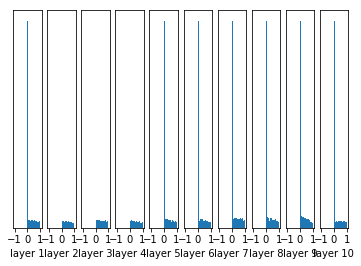

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

graph = tf.Graph()
with graph.as_default():
    data = tf.constant(np.random.randn(100, 100).astype('float32'))
    layer_sizes = [100 - 5 * i for i in range(0, 11)]
    print('layer_sizes:',layer_sizes)
    num_layers = len(layer_sizes)

    fcs = []
    layer_input = []
    Ws = []
    for i in range(0, num_layers-1):
        X = data if i == 0 else fcs[i - 1]
        node_in = layer_sizes[i]
        node_out = layer_sizes[i + 1]
        W = tf.Variable(np.random.randn(node_in, node_out).astype('float32'))/np.sqrt(node_in/2)
        fc = tf.matmul(X, W)
        fc = tf.nn.relu(fc)
        
        fcs.append(fc)
        Ws.append(W)
        layer_input.append(X)

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())

    print('input mean {0:.5f} and std {1:.5f}'.format(np.mean(data.eval()),np.var(data.eval())))
    for idx, fc in enumerate(fcs):
        print('layer {0} mean {1:.5f} and layer_output var {2:.5f} and layer_input var {3:.5f} and  layer_weight var {4:.5f}'.format(idx + 1, np.mean(fc.eval()),
                                                              np.var(fc.eval()),np.var(layer_input[idx].eval()),np.var(Ws[idx].eval())))
    plt.figure()
    for idx, fc in enumerate(fcs):
        plt.subplot(1, len(fcs), idx + 1)
        plt.hist(fc.eval().flatten(), 30, range=[-1,1])
        plt.xlabel('layer ' + str(idx + 1))
        plt.yticks([])

    plt.show()
    sess.close()

## 5. Batch Normalization
Batch Normalization是一种巧妙而粗暴的方法来削弱bad initialization的影响，其基本思想是：If you want it, just make it!

我们想要的是在非线性activation之前，输出值应该有比较好的分布（例如高斯分布），以便于back propagation时计算gradient，更新weight。Batch Normalization将输出值强行做一次Gaussian Normalization和线性变换
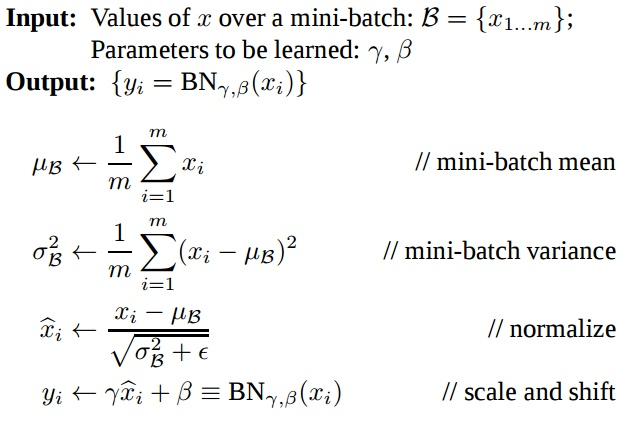

Batch Normalization中所有的操作都是平滑可导，这使得back propagation可以有效运行并学到相应的参数$\gamma，\beta$。需要注意的一点是Batch Normalization在training和testing时行为有所差别。Training时$\mu_\mathcal{B}和\sigma_\mathcal{B}$由当前batch计算得出；在Testing时$\mu_\mathcal{B}和\sigma_\mathcal{B}$应使用Training时保存的均值或类似的经过处理的值，而不是由当前batch计算。

input mean -0.00206 and std 0.99954
layer 1 mean 0.39905 and std 0.58339
layer 2 mean 0.39866 and std 0.58407
layer 3 mean 0.39856 and std 0.58427
layer 4 mean 0.39825 and std 0.58418
layer 5 mean 0.39800 and std 0.58489
layer 6 mean 0.39760 and std 0.58504
layer 7 mean 0.39713 and std 0.58495
layer 8 mean 0.39637 and std 0.58537
layer 9 mean 0.39613 and std 0.58723


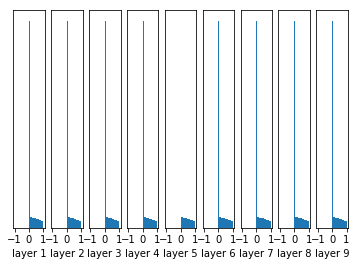

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

graph = tf.Graph()
with graph.as_default():
  data = tf.constant(np.random.randn(2000, 800).astype('float32'))
  layer_sizes = [800 - 50 * i for i in range(0,10)]
  num_layers = len(layer_sizes)
  
  fcs = []
  for i in range(0, num_layers - 1):
    X = data if i == 0 else fcs[i - 1]
    node_in = layer_sizes[i]
    node_out = layer_sizes[i + 1]
    W = tf.Variable(np.random.randn(node_in, node_out).astype('float32')) * np.sqrt(node_in)
    fc = tf.matmul(X, W)
    fc = tf.contrib.layers.batch_norm(fc, center=True, scale=True,
                                      is_training=True)
    fc = tf.nn.relu(fc)
    fcs.append(fc)
    
with tf.Session(graph=graph) as sess:
  sess.run(tf.global_variables_initializer())
  
  print('input mean {0:.5f} and std {1:.5f}'.format(np.mean(data.eval()),
                                          np.std(data.eval())))
  for idx, fc in enumerate(fcs):
    print('layer {0} mean {1:.5f} and std {2:.5f}'.format(idx+1, np.mean(fc.eval()),
                                               np.std(fc.eval())))
  
  plt.figure()
  for idx, fc in enumerate(fcs):
    plt.subplot(1, len(fcs), idx+1)
    plt.hist(fc.eval().flatten(), 30, range=[-1,1])
    plt.yticks([])
    plt.xlabel('layer ' + str(idx + 1))

## Reference
https://zhuanlan.zhihu.com/p/25110150      
https://zhuanlan.zhihu.com/p/22028079    
https://www.zhihu.com/question/41631631